In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [42]:
raw_data = pd.read_csv(r'HR_Employee_Attrition_Data.csv')
raw_data.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,1102,1,2,1,1,2,94,3,2,4,5993,19479,8,11,3,1,80,0,8,0,1,6,4,0,5
1,49,0,279,8,1,1,2,3,61,2,2,2,5130,24907,1,23,4,4,80,1,10,3,3,10,7,1,7
2,37,1,1373,2,2,1,3,4,92,2,1,3,2090,2396,6,15,3,2,80,0,7,3,3,0,0,0,0
3,33,0,1392,3,4,1,4,4,56,3,1,3,2909,23159,1,11,3,3,80,0,8,3,3,8,7,3,0
4,27,0,591,2,1,1,5,1,40,3,1,2,3468,16632,9,12,3,4,80,1,6,3,3,2,2,2,2


In [43]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       2940 non-null   int64
 1   Attrition                 2940 non-null   int64
 2   DailyRate                 2940 non-null   int64
 3   DistanceFromHome          2940 non-null   int64
 4   Education                 2940 non-null   int64
 5   EmployeeCount             2940 non-null   int64
 6   EmployeeNumber            2940 non-null   int64
 7   EnvironmentSatisfaction   2940 non-null   int64
 8   HourlyRate                2940 non-null   int64
 9   JobInvolvement            2940 non-null   int64
 10  JobLevel                  2940 non-null   int64
 11  JobSatisfaction           2940 non-null   int64
 12  MonthlyIncome             2940 non-null   int64
 13  MonthlyRate               2940 non-null   int64
 14  NumCompaniesWorked        2940 non-null 

In [44]:
raw_data = raw_data.drop(['EmployeeCount','EmployeeNumber'], axis=1)

In [45]:
raw_data.shape

(2940, 25)

In [46]:
X = raw_data.drop(['Attrition'], axis=1)
y = raw_data.pop('Attrition')

In [47]:
X_train, X_test, train_labels, test_labels = train_test_split(X,y,test_size=0.3, random_state=1)

In [48]:
dt = DecisionTreeClassifier(criterion='gini')

In [49]:
dt.fit(X_train, train_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [50]:
from sklearn import tree

In [51]:
train_char_labels = ['No','Yes']

tree_graph = open(r'./hr_attrition_dt.dot','w')

dot_data = tree.export_graphviz(dt, out_file = tree_graph, feature_names = list(X_train), class_names = train_char_labels)

tree_graph.close()

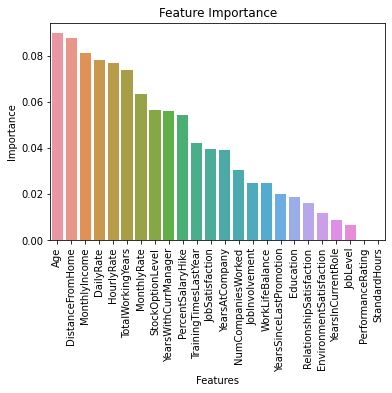

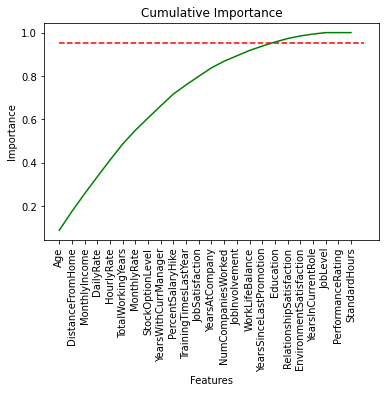

In [52]:
importances = pd.DataFrame(dt.feature_importances_, columns = ['Imp'], index = X_train.columns)
importances['features'] = pd.DataFrame(dt.feature_importances_, columns = ['Imp'], index = X_train.columns).index
importances.reset_index

importances = importances.sort_values(by='Imp', ascending=False)
importances.set_index(np.arange(0,importances.shape[0]),inplace = True)

importances['cumsum'] = np.cumsum(importances.Imp)
x_vals = list(range(len(importances)))

sns.barplot(data = importances, x='features', y='Imp')
plt.xticks(x_vals, importances['features'], rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Features'); plt.title('Feature Importance');
plt.show()

plt.plot(x_vals, importances['cumsum'], 'g-')
plt.hlines(y = 0.95, xmin=0, xmax=len(importances), color = 'r', linestyles = 'dashed')
plt.xticks(x_vals, importances['features'], rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Features'); plt.title('Cumulative Importance');
plt.show()

In [53]:
dt_param_grid = {
    'max_depth' : [5,6,7,8,9,10,11,12],
    'min_samples_leaf' : [15,20,25,30],
    'min_samples_split' : [50,60,75,90,100]
}

In [54]:
dt_ht = DecisionTreeClassifier()

In [55]:
dt_gs = GridSearchCV(estimator=dt_ht, param_grid=dt_param_grid, cv = 3)

In [56]:
dt_gs.fit(X_train, train_labels)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
           

In [57]:
dt_gs.best_params_

{'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 50}

In [58]:
best_dt = dt_gs.best_estimator_

In [59]:
ytrain_predict = best_dt.predict(X_train)
ytest_predict = best_dt.predict(X_test)

In [60]:
#Train data Confusion Matrix
print(confusion_matrix(train_labels, ytrain_predict))
#Train Data Accuracy
print(best_dt.score(X_train,train_labels) )
print(classification_report(train_labels, ytrain_predict))

[[1691   46]
 [ 226   95]]
0.8678328474246841
              precision    recall  f1-score   support

           0       0.88      0.97      0.93      1737
           1       0.67      0.30      0.41       321

    accuracy                           0.87      2058
   macro avg       0.78      0.63      0.67      2058
weighted avg       0.85      0.87      0.85      2058



In [61]:
#Test data Confusion Matrix
print(confusion_matrix(test_labels, ytest_predict))
#Test Data Accuracy
print(best_dt.score(X_test,test_labels) )
print(classification_report(test_labels, ytest_predict))

[[701  28]
 [122  31]]
0.8299319727891157
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       729
           1       0.53      0.20      0.29       153

    accuracy                           0.83       882
   macro avg       0.69      0.58      0.60       882
weighted avg       0.80      0.83      0.80       882



In [62]:
probs = best_dt.predict_proba(X_train)[:,1]
auc_dev = roc_auc_score(train_labels, probs)
print(auc_dev)
fpr, tpr, thresholds = roc_curve(train_labels, probs)

0.8705595819052794


In [63]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.208333, G-Mean=0.800


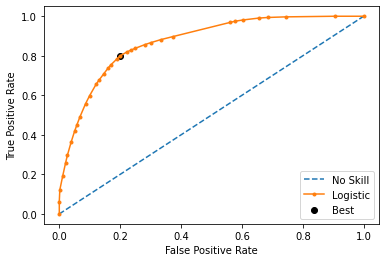

In [64]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [65]:
rf_param_grid = {
    'max_depth' : [5,6],
    'min_samples_leaf' : [10,15,20,30],
    'min_samples_split' : [40,50,60],
    'max_features' : [5,6],
    'n_estimators' : [100]
}

In [66]:
rf_ht = RandomForestClassifier()
rf_gs = GridSearchCV(estimator=rf_ht, param_grid=rf_param_grid, cv = 3)
rf_gs.fit(X_train, train_labels)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [67]:
rf_gs.best_params_

{'max_depth': 6,
 'max_features': 6,
 'min_samples_leaf': 10,
 'min_samples_split': 40,
 'n_estimators': 100}

In [68]:
best_rf = rf_gs.best_estimator_

In [69]:
ytrain_predict = best_rf.predict(X_train)
ytest_predict = best_rf.predict(X_test)

In [70]:
#Train data Confusion Matrix
print(confusion_matrix(train_labels, ytrain_predict))
#Train Data Accuracy
print(best_rf.score(X_train,train_labels) )
print(classification_report(train_labels, ytrain_predict))

[[1733    4]
 [ 280   41]]
0.8620019436345967
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1737
           1       0.91      0.13      0.22       321

    accuracy                           0.86      2058
   macro avg       0.89      0.56      0.57      2058
weighted avg       0.87      0.86      0.82      2058



In [71]:
#Test data Confusion Matrix
print(confusion_matrix(test_labels, ytest_predict))
#Test Data Accuracy
print(best_rf.score(X_test,test_labels) )
print(classification_report(test_labels, ytest_predict))

[[725   4]
 [136  17]]
0.8412698412698413
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       729
           1       0.81      0.11      0.20       153

    accuracy                           0.84       882
   macro avg       0.83      0.55      0.55       882
weighted avg       0.84      0.84      0.79       882



In [72]:
probs = best_rf.predict_proba(X_train)[:,1]
auc_dev = roc_auc_score(train_labels, probs)
print(auc_dev)
fpr, tpr, thresholds = roc_curve(train_labels, probs)

0.9173262168274516


In [73]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.180213, G-Mean=0.846


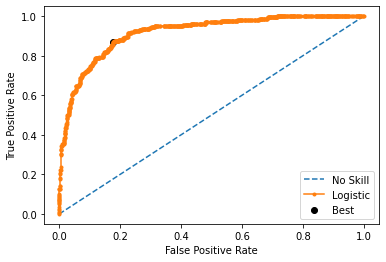

In [74]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [75]:
ss = StandardScaler()

In [76]:
X_train_s = ss.fit_transform(X_train)

In [77]:
X_test_s = ss.transform(X_test)

In [78]:
X_train_s

array([[ 1.75904517,  1.04289644, -0.27238444, ...,  0.76397248,
         0.56720724,  0.82525338],
       [ 0.2198339 , -1.64621765, -0.76671175, ..., -0.33955822,
         0.25683434,  0.54043509],
       [-0.10999708, -0.5899575 ,  1.08701567, ..., -1.16720624,
        -0.67428439, -1.16847464],
       ...,
       [ 0.32977756,  0.23516808, -0.39596627, ...,  0.76397248,
         1.49832597,  0.82525338],
       [ 0.65960855,  0.57317133,  0.83985201, ...,  2.41926852,
        -0.36391148,  1.39488995],
       [-1.42932103,  0.06616646,  0.46910653, ..., -1.16720624,
        -0.67428439, -1.16847464]])

In [125]:
nn_param_grid = {
    'hidden_layer_sizes' : [100],
    'activation' : ['relu'],
    'solver' : ['sgd','adam'],
    'max_iter' : [10000],
    'tol' : [0.0001],
    'verbose' : [True]
}

In [126]:
nn_ht = MLPClassifier()
nn_gs = GridSearchCV(estimator=nn_ht, param_grid=nn_param_grid, cv = 3)
nn_gs.fit(X_train_s, train_labels)

Streaming output truncated to the last 5000 lines.
Iteration 258, loss = 0.34026146
Iteration 259, loss = 0.34012740
Iteration 260, loss = 0.33996013
Iteration 261, loss = 0.33980254
Iteration 262, loss = 0.33965062
Iteration 263, loss = 0.33947268
Iteration 264, loss = 0.33934228
Iteration 265, loss = 0.33917287
Iteration 266, loss = 0.33901476
Iteration 267, loss = 0.33885731
Iteration 268, loss = 0.33872472
Iteration 269, loss = 0.33855275
Iteration 270, loss = 0.33839331
Iteration 271, loss = 0.33825857
Iteration 272, loss = 0.33809140
Iteration 273, loss = 0.33793891
Iteration 274, loss = 0.33779285
Iteration 275, loss = 0.33763890
Iteration 276, loss = 0.33749089
Iteration 277, loss = 0.33734537
Iteration 278, loss = 0.33720209
Iteration 279, loss = 0.33704224
Iteration 280, loss = 0.33688794
Iteration 281, loss = 0.33673360
Iteration 282, loss = 0.33658836
Iteration 283, loss = 0.33645093
Iteration 284, loss = 0.33628757
Iteration 285, loss = 0.33614658
Iteration 286, loss = 0.3

GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=

In [127]:
nn_gs.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': 100,
 'max_iter': 10000,
 'solver': 'adam',
 'tol': 0.0001,
 'verbose': True}

In [132]:
best_nn = nn_gs.best_estimator_
best_nn

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=100, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [129]:
ytrain_predict = best_nn.predict(X_train_s)
ytest_predict = best_nn.predict(X_test_s)

In [130]:
#Train data Confusion Matrix
print(confusion_matrix(train_labels, ytrain_predict))
#Train Data Accuracy
print(best_rf.score(X_train,train_labels) )
print(classification_report(train_labels, ytrain_predict))

[[1737    0]
 [   0  321]]
0.8620019436345967
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1737
           1       1.00      1.00      1.00       321

    accuracy                           1.00      2058
   macro avg       1.00      1.00      1.00      2058
weighted avg       1.00      1.00      1.00      2058



In [131]:
#Test data Confusion Matrix
print(confusion_matrix(test_labels, ytest_predict))
#Test Data Accuracy
print(best_rf.score(X_test,test_labels) )
print(classification_report(test_labels, ytest_predict))

[[707  22]
 [ 38 115]]
0.8412698412698413
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       729
           1       0.84      0.75      0.79       153

    accuracy                           0.93       882
   macro avg       0.89      0.86      0.88       882
weighted avg       0.93      0.93      0.93       882



In [134]:
probs = best_nn.predict_proba(X_train_s)[:,1]
auc_train = roc_auc_score(train_labels, probs)
print(auc_train)
fpr, tpr, thresholds = roc_curve(train_labels, probs)

1.0


In [135]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.749029, G-Mean=1.000


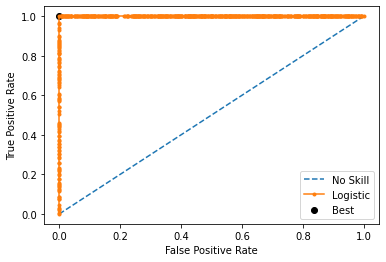

In [136]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [137]:
probt = best_nn.predict_proba(X_test_s)[:,1]
auc_test = roc_auc_score(test_labels, probt)
print(auc_test)
fpr, tpr, thresholds = roc_curve(test_labels, probt)

0.8764356222598778


In [138]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.749029, G-Mean=0.860


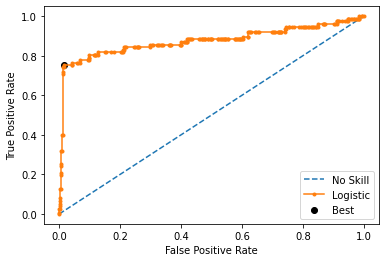

In [139]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()